# **RETO DaCiberSalut**

# Autores: Iván Falcón Monzón, Ismael Díaz Sancha, David Rodríguez Gerrard

# 1. Descarga y preparación del dataset

In [12]:
# 📁 Descarga y organización del dataset
## En esta sección se descarga el dataset de Kaggle y se reestructura el conjunto de datos en un único directorio plano compatible con `ImageFolder` de PyTorch.

In [13]:
import kagglehub
import os
import shutil

# Descargar el dataset desde KaggleHub
path = kagglehub.dataset_download("andrewmvd/lung-and-colon-cancer-histopathological-images")
original_root = os.path.join(path, "lung_colon_image_set")
flattened_root = "/kaggle/working/flattened_dataset"
os.makedirs(flattened_root, exist_ok=True)

# Mapeo de clases a sus carpetas originales
clase_map = {
    "colon_aca": os.path.join(original_root, "colon_image_sets", "colon_aca"),
    "colon_n": os.path.join(original_root, "colon_image_sets", "colon_n"),
    "lung_aca": os.path.join(original_root, "lung_image_sets", "lung_aca"),
    "lung_n": os.path.join(original_root, "lung_image_sets", "lung_n"),
    "lung_scc": os.path.join(original_root, "lung_image_sets", "lung_scc")
}

# Copiar todas las imágenes a un solo directorio estructurado por clases
for class_name, source_dir in clase_map.items():
    dest_dir = os.path.join(flattened_root, class_name)
    os.makedirs(dest_dir, exist_ok=True)
    for img_name in os.listdir(source_dir):
        shutil.copyfile(os.path.join(source_dir, img_name), os.path.join(dest_dir, img_name))

print("✅ Dataset reorganizado en:", flattened_root)

✅ Dataset reorganizado en: /kaggle/working/flattened_dataset


# 2. Transformaciones y carga del dataset

In [ ]:
# Transformaciones y carga del dataset con ImageFolder
## Se aplica redimensionamiento, conversión a tensor y normalización. Luego se carga usando `ImageFolder`.

In [14]:
from torchvision import datasets, transforms

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Cargar el dataset
dataset = datasets.ImageFolder(root=flattened_root, transform=transform)
print("📦 Dataset cargado con clases:", dataset.classes)

📦 Dataset cargado con clases: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


# 3. División en conjunto de entrenamiento y validación

In [15]:
# 🔀 División del dataset
## Se divide el dataset en 80% entrenamiento y 20% validación.

In [16]:
import torch
from torch.utils.data import random_split, DataLoader

# División del dataset
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"📊 Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")

# Carga por lotes
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

📊 Train samples: 20000 | Val samples: 5000


# 4. Definición del modelo ResNet50

In [18]:
# 🧠 Definición del modelo
## Se utiliza un modelo preentrenado ResNet50, se congela el feature extractor y se ajusta la capa final para clasificación.

In [17]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Modelo preentrenado
model = models.resnet50(pretrained=True)

# Congelar parámetros
for param in model.parameters():
    param.requires_grad = False

# Ajustar la capa final al número de clases
num_classes = len(dataset.classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)

# Pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 41.8MB/s]


# 5. Entrenamiento y validación

In [19]:
# 🔁 Entrenamiento del modelo
## Bucle de entrenamiento durante `n` épocas con validación al final de cada una.

In [20]:
num_epochs = 5

for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset)

    # Validación
    model.eval()
    val_loss, val_corrects = 0.0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels).item()

    val_loss /= len(val_dataset)
    val_acc = val_corrects / len(val_dataset)

    print(f"📍 Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

📍 Epoch 1/5 | Train Loss: 0.3101 | Train Acc: 0.8849 | Val Loss: 0.0916 | Val Acc: 0.9656
📍 Epoch 2/5 | Train Loss: 0.1960 | Train Acc: 0.9254 | Val Loss: 0.0665 | Val Acc: 0.9748
📍 Epoch 3/5 | Train Loss: 0.1809 | Train Acc: 0.9325 | Val Loss: 0.0587 | Val Acc: 0.9802
📍 Epoch 4/5 | Train Loss: 0.1646 | Train Acc: 0.9376 | Val Loss: 0.0573 | Val Acc: 0.9788
📍 Epoch 5/5 | Train Loss: 0.1566 | Train Acc: 0.9422 | Val Loss: 0.0572 | Val Acc: 0.9792


# 6. Guardar el modelo entrenado

In [21]:
# 💾 Guardado del modelo entrenado
## Se guarda el `state_dict` del modelo entrenado para uso posterior.

In [22]:
torch.save(model.state_dict(), "resnet50_cancer.pth")
print("✅ Modelo guardado como resnet50_cancer.pth")

✅ Modelo guardado como resnet50_cancer.pth


# 7. Carga del modelo para inferencia

In [23]:
# 🔍 Carga y evaluación del modelo entrenado
## Se define la arquitectura, se cargan los pesos guardados y se preparan las imágenes para predicción.

In [24]:
from PIL import Image
import io
from google.colab import files

# Definir arquitectura y cargar pesos
modelo = models.resnet50(weights=None)
modelo.fc = nn.Linear(modelo.fc.in_features, num_classes)
modelo.load_state_dict(torch.load("resnet50_cancer.pth", map_location=device))
modelo.to(device)
modelo.eval()

# Transformaciones para inferencia
transformaciones = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Cargar imagen del usuario
archivos_subidos = files.upload()

# Inferencia
for nombre_archivo, contenido in archivos_subidos.items():
    imagen = Image.open(io.BytesIO(contenido)).convert('RGB')
    imagen_transformada = transformaciones(imagen).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = modelo(imagen_transformada)
        probabilidades = torch.nn.functional.softmax(outputs, dim=1)

    print(f"\n🖼️ Imagen: {nombre_archivo}")
    for i, prob in enumerate(probabilidades[0]):
        print(f"  {dataset.classes[i]}: {prob.item():.4f}")

Saving colonca4783.jpeg to colonca4783.jpeg

🖼️ Imagen: colonca4783.jpeg
  colon_aca: 1.0000
  colon_n: 0.0000
  lung_aca: 0.0000
  lung_n: 0.0000
  lung_scc: 0.0000


# 8. Visualización: distribución de clases

In [25]:
# 📊 Distribución de imágenes por clase
## Muestra cuántas imágenes hay por clase en el dataset reorganizado.

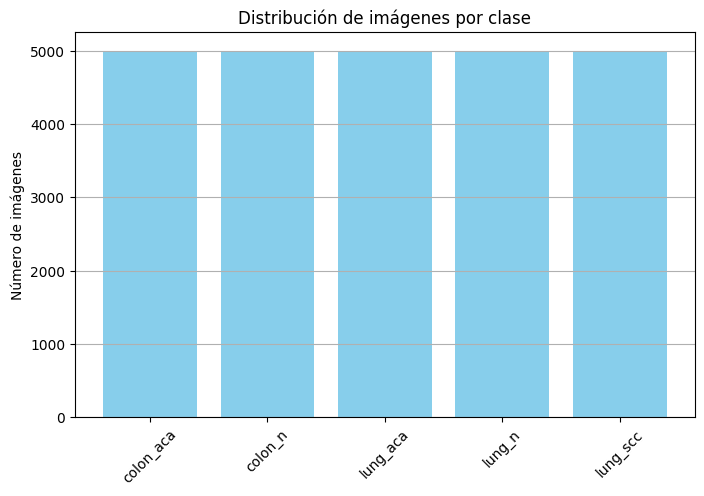

In [26]:
import matplotlib.pyplot as plt
from collections import Counter

# Contar clases en dataset completo
class_counts = Counter([dataset.samples[i][1] for i in range(len(dataset))])
class_labels = dataset.classes
counts = [class_counts[i] for i in range(len(class_labels))]

# Graficar
plt.figure(figsize=(8, 5))
plt.bar(class_labels, counts, color="skyblue")
plt.title("Distribución de imágenes por clase")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 9. Matriz de confusión

In [27]:
# 🔀 Matriz de confusión
## Muestra cómo se distribuyen las predicciones correctas e incorrectas por clase.

<Figure size 700x700 with 0 Axes>

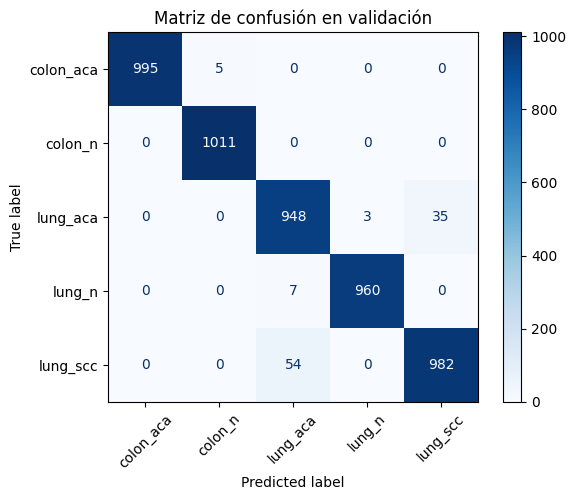

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener todas las predicciones y etiquetas verdaderas
y_true, y_pred = [], []

modelo.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = modelo(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

# Mostrar
plt.figure(figsize=(7, 7))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de confusión en validación")
plt.show()

# 10. Clasificación por clase: precisión, recall y F1-score

In [29]:
# 📋 Métricas por clase
## Se muestran métricas detalladas como precisión, recall y F1-score por clase.

In [30]:
from sklearn.metrics import classification_report

# Clasificación detallada
print("📋 Clasificación por clase:\n")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

📋 Clasificación por clase:

              precision    recall  f1-score   support

   colon_aca       1.00      0.99      1.00      1000
     colon_n       1.00      1.00      1.00      1011
    lung_aca       0.94      0.96      0.95       986
      lung_n       1.00      0.99      0.99       967
    lung_scc       0.97      0.95      0.96      1036

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



# **11. Visualización de imágenes y predicciones**

In [31]:
# 🖼️ Visualización de predicciones
## Muestra imágenes aleatorias con sus etiquetas reales y predichas.

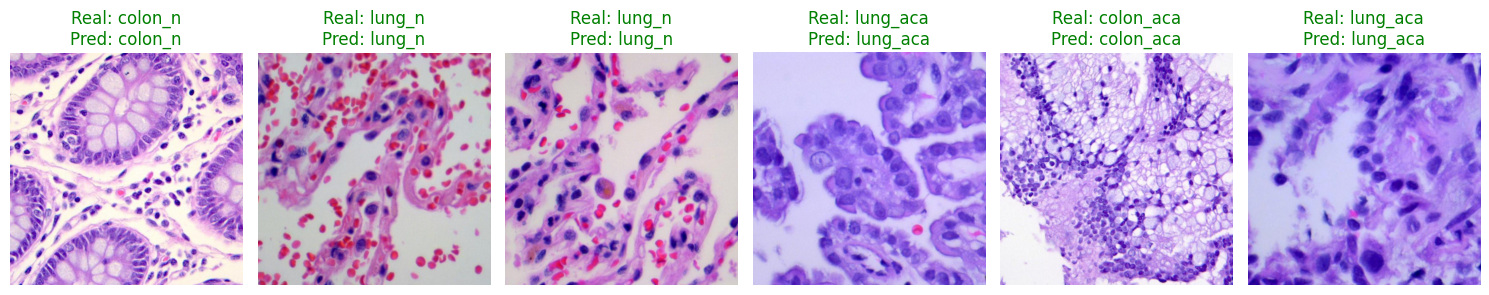

In [32]:
import numpy as np

def mostrar_predicciones(modelo, loader, clases, cantidad=6):
    modelo.eval()
    inputs_iter, labels_iter = next(iter(loader))
    inputs_iter = inputs_iter[:cantidad].to(device)
    labels_iter = labels_iter[:cantidad]

    with torch.no_grad():
        outputs = modelo(inputs_iter)
        _, preds = torch.max(outputs, 1)

    # Visualizar
    plt.figure(figsize=(15, 5))
    for i in range(cantidad):
        img = inputs_iter[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # desnormalizar
        img = np.clip(img, 0, 1)

        plt.subplot(1, cantidad, i+1)
        plt.imshow(img)
        color = 'green' if preds[i] == labels_iter[i] else 'red'
        plt.title(f"Real: {clases[labels_iter[i]]}\nPred: {clases[preds[i]]}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Ejecutar visualización
mostrar_predicciones(modelo, val_loader, dataset.classes)

# **12. Modelo utilizado – ResNet50**

## Arquitectura CNN preentrenada para clasificación de imágenes histopatológicas

### 📌 ¿Qué es ResNet50?
**ResNet50** es una red neuronal convolucional profunda compuesta por 50 capas. Forma parte de la familia de arquitecturas ResNet (Residual Networks) desarrolladas por Microsoft Research. Su principal innovación es el uso de **bloques residuales** o "skip connections", que permiten entrenar redes muy profundas sin sufrir el problema del **desvanecimiento del gradiente**.

### ⚙️ ¿Qué hace en este proyecto?
En este código, usamos `torchvision.models.resnet50(pretrained=True)` para cargar el modelo ResNet50 **preentrenado con ImageNet**. Esto permite **aprovechar el conocimiento previo aprendido** con millones de imágenes genéricas y aplicarlo a nuestro conjunto de datos médico (transfer learning).

```python
model = models.resnet50(pretrained=True)


Luego, congelamos las capas convolucionales (param.requires_grad = False) para no modificarlas y solo entrenamos la capa final, que se adapta al número de clases de nuestro problema (5 tipos de tejidos: colon_aca, colon_n, lung_aca, lung_n, lung_scc).

num_features = model.fc.in_features

model.fc = nn.Linear(num_features, num_classes)

🎯¿Qué aporta ResNet50 en este contexto?

✅ **Precisión**: Su arquitectura profunda permite aprender representaciones muy complejas y detalladas de las imágenes.

✅ **Eficiencia**: Gracias al entrenamiento previo, el modelo converge más rápido y necesita menos datos etiquetados.

✅ **Generalización**: La estructura residual mejora el flujo del gradiente, evitando problemas comunes de entrenamiento.

📌 **Resultado**
El uso de ResNet50 como backbone permite obtener un modelo robusto y preciso para la tarea de clasificación de imágenes histopatológicas, logrando detectar con alta precisión distintos tipos de cáncer en tejidos de colon y pulmón.